# Integrated Production & Risk Analysis

This notebook demonstrates the **complete operational planning workflow** by integrating:

1. **Production System Modeling** - Multi-well system with process equipment
2. **Bottleneck Analysis** - Identifying system constraints
3. **Risk Simulation** - Monte Carlo analysis of equipment failures
4. **Risk Matrix** - Visual risk assessment with consequence/probability
5. **Portfolio Analysis** - Multi-asset risk aggregation
6. **Operational Decision Support** - Well prioritization under uncertainty

## Business Value

This integrated approach answers key operational questions:
- What is our **expected production availability**?
- Which equipment poses the **highest risk** to production?
- How should we **prioritize wells** considering both capacity and risk?
- What is the **economic impact** of different production strategies?

## System Overview

```
Well A (Low GOR)  ──┐                                      ┌── Gas Export
                    ├── Manifold ── Separator ── Compressor ┤
Well B (High GOR) ──┤                    │                  └── (Reliability: 95%)
                    │                    │
Well C (High WC)  ──┘                    └── Oil/Water Export
                                              (Reliability: 98%)
```

## 1. Setup and Imports

In [1]:
# Import NeqSim
from neqsim import jneqsim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch
import warnings
warnings.filterwarnings('ignore')

# Thermo systems
SystemSrkEos = jneqsim.thermo.system.SystemSrkEos
ThermodynamicOperations = jneqsim.thermodynamicoperations.ThermodynamicOperations

# Process equipment
ProcessSystem = jneqsim.process.processmodel.ProcessSystem
Stream = jneqsim.process.equipment.stream.Stream
Mixer = jneqsim.process.equipment.mixer.Mixer
ThreePhaseSeparator = jneqsim.process.equipment.separator.ThreePhaseSeparator
Compressor = jneqsim.process.equipment.compressor.Compressor
ThrottlingValve = jneqsim.process.equipment.valve.ThrottlingValve
Cooler = jneqsim.process.equipment.heatexchanger.Cooler

# Risk Framework
OperationalRiskSimulator = jneqsim.process.safety.risk.OperationalRiskSimulator
RiskMatrix = jneqsim.process.safety.risk.RiskMatrix
DynamicRiskSimulator = jneqsim.process.safety.risk.dynamic.DynamicRiskSimulator
PortfolioRiskAnalyzer = jneqsim.process.safety.risk.portfolio.PortfolioRiskAnalyzer

print("NeqSim loaded successfully!")
print("- Process equipment classes")
print("- Risk simulation framework")
print("- Portfolio risk analyzer")

NeqSim loaded successfully!
- Process equipment classes
- Risk simulation framework
- Portfolio risk analyzer


## 2. Create Well Fluids

Three wells with different characteristics:
- **Well A**: Low GOR, Low Water Cut - Best producer
- **Well B**: High GOR - Gas-rich, stresses compression
- **Well C**: High Water Cut - Mature well, stresses water handling

In [2]:
def create_well_fluid(gor_type='medium', water_cut=0.0, temperature_K=350.0, pressure_bara=80.0):
    """Create well fluid with specified characteristics."""
    fluid = SystemSrkEos(temperature_K, pressure_bara)
    
    if gor_type == 'low':
        # Low GOR - more heavy components
        fluid.addComponent("nitrogen", 0.005)
        fluid.addComponent("CO2", 0.015)
        fluid.addComponent("methane", 0.25)
        fluid.addComponent("ethane", 0.06)
        fluid.addComponent("propane", 0.05)
        fluid.addComponent("i-butane", 0.015)
        fluid.addComponent("n-butane", 0.03)
        fluid.addComponent("i-pentane", 0.02)
        fluid.addComponent("n-pentane", 0.025)
        fluid.addComponent("n-hexane", 0.03)
        fluid.addComponent("n-heptane", 0.50)
    elif gor_type == 'high':
        # High GOR - more light components
        fluid.addComponent("nitrogen", 0.01)
        fluid.addComponent("CO2", 0.03)
        fluid.addComponent("methane", 0.55)
        fluid.addComponent("ethane", 0.10)
        fluid.addComponent("propane", 0.06)
        fluid.addComponent("i-butane", 0.02)
        fluid.addComponent("n-butane", 0.03)
        fluid.addComponent("i-pentane", 0.015)
        fluid.addComponent("n-pentane", 0.02)
        fluid.addComponent("n-hexane", 0.015)
        fluid.addComponent("n-heptane", 0.15)
    else:  # medium
        fluid.addComponent("nitrogen", 0.008)
        fluid.addComponent("CO2", 0.02)
        fluid.addComponent("methane", 0.40)
        fluid.addComponent("ethane", 0.08)
        fluid.addComponent("propane", 0.055)
        fluid.addComponent("i-butane", 0.018)
        fluid.addComponent("n-butane", 0.03)
        fluid.addComponent("i-pentane", 0.018)
        fluid.addComponent("n-pentane", 0.022)
        fluid.addComponent("n-hexane", 0.022)
        fluid.addComponent("n-heptane", 0.327)
    
    if water_cut > 0.01:
        fluid.addComponent("water", water_cut * 0.5)
    
    fluid.setMixingRule("classic")
    fluid.setMultiPhaseCheck(True)
    
    ops = ThermodynamicOperations(fluid)
    ops.TPflash()
    
    return fluid

# Create well fluids
well_configs = {
    'Well_A': {'gor_type': 'low', 'water_cut': 0.05, 'desc': 'Low GOR, Low WC'},
    'Well_B': {'gor_type': 'high', 'water_cut': 0.10, 'desc': 'High GOR'},
    'Well_C': {'gor_type': 'medium', 'water_cut': 0.50, 'desc': 'High WC'},
}

well_fluids = {}
print("Well Fluid Characteristics:")
print("=" * 50)
for name, config in well_configs.items():
    fluid = create_well_fluid(config['gor_type'], config['water_cut'])
    well_fluids[name] = fluid
    print(f"{name}: {config['desc']}")
    if fluid.hasPhaseType('gas'):
        gas_frac = fluid.getPhase('gas').getVolume() / fluid.getVolume()
        print(f"  Gas volume fraction: {gas_frac:.2%}")
    print()

Well Fluid Characteristics:
Well_A: Low GOR, Low WC

Well_B: High GOR
  Gas volume fraction: 79.42%

Well_C: High WC
  Gas volume fraction: 47.34%



## 3. Build Production System

Build the complete production system with equipment that will be subject to risk analysis.

In [3]:
def build_production_system(well_rates, sep_pressure=25.0, compressor_outlet_pressure=80.0):
    """
    Build complete production system.
    
    Returns: (ProcessSystem, equipment_dict)
    """
    process = ProcessSystem()
    equipment = {}
    
    # Create well streams with chokes
    well_outlets = []
    for well_name, rate in well_rates.items():
        if rate > 0:
            fluid = well_fluids[well_name].clone()
            stream = Stream(f"{well_name}_stream", fluid)
            stream.setFlowRate(float(rate), "kg/hr")
            process.add(stream)
            equipment[f"{well_name}_stream"] = stream
            
            choke = ThrottlingValve(f"{well_name}_choke", stream)
            choke.setOutletPressure(sep_pressure + 5.0)
            process.add(choke)
            equipment[f"{well_name}_choke"] = choke
            
            well_outlets.append(choke.getOutletStream())
    
    if len(well_outlets) == 0:
        return None, None
    
    # Manifold
    if len(well_outlets) > 1:
        manifold = Mixer("manifold")
        for outlet in well_outlets:
            manifold.addStream(outlet)
        process.add(manifold)
        equipment['manifold'] = manifold
        manifold_outlet = manifold.getOutletStream()
    else:
        manifold_outlet = well_outlets[0]
    
    # Three-phase separator
    separator = ThreePhaseSeparator("HP_Separator", manifold_outlet)
    process.add(separator)
    equipment['separator'] = separator
    
    # Gas compression
    gas_stream = separator.getGasOutStream()
    
    compressor = Compressor("Gas_Compressor", gas_stream)
    compressor.setOutletPressure(compressor_outlet_pressure)
    compressor.setIsentropicEfficiency(0.75)
    compressor.setUsePolytropicCalc(True)
    compressor.setPolytropicEfficiency(0.70)
    process.add(compressor)
    equipment['compressor'] = compressor
    
    # Gas cooler
    cooler = Cooler("Gas_Cooler", compressor.getOutletStream())
    cooler.setOutTemperature(273.15 + 35.0)
    process.add(cooler)
    equipment['cooler'] = cooler
    
    # Run the process
    process.run()
    
    return process, equipment

# Build base case system
base_rates = {'Well_A': 15000.0, 'Well_B': 12000.0, 'Well_C': 8000.0}
process, equipment = build_production_system(base_rates)

print("Production System Built Successfully!")
print("=" * 50)
print(f"Total feed rate: {sum(base_rates.values()):.0f} kg/hr")
print(f"\nEquipment count: {len(equipment)}")
for name in equipment:
    print(f"  - {name}")

Production System Built Successfully!
Total feed rate: 35000 kg/hr

Equipment count: 10
  - Well_A_stream
  - Well_A_choke
  - Well_B_stream
  - Well_B_choke
  - Well_C_stream
  - Well_C_choke
  - manifold
  - separator
  - compressor
  - cooler


## 4. Equipment Performance Analysis

Analyze system performance and identify bottlenecks before adding risk.

In [4]:
def analyze_system_performance(process, equipment):
    """Analyze production system performance."""
    results = {}
    
    # Separator performance
    sep = equipment['separator']
    gas_out = sep.getGasOutStream()
    oil_out = sep.getOilOutStream()
    
    results['gas_rate_kg_hr'] = gas_out.getFlowRate("kg/hr")
    results['oil_rate_kg_hr'] = oil_out.getFlowRate("kg/hr")
    results['sep_pressure_bara'] = sep.getPressure()
    results['sep_temperature_C'] = sep.getTemperature() - 273.15
    
    # Compressor performance
    comp = equipment['compressor']
    results['compressor_power_kW'] = comp.getPower() / 1000.0
    results['compressor_outlet_T_C'] = comp.getOutletStream().getTemperature() - 273.15
    results['compression_ratio'] = comp.getOutletStream().getPressure() / gas_out.getPressure()
    
    # Cooler duty
    cooler = equipment['cooler']
    results['cooler_duty_kW'] = abs(cooler.getDuty()) / 1000.0
    results['export_gas_T_C'] = cooler.getOutletStream().getTemperature() - 273.15
    
    return results

perf = analyze_system_performance(process, equipment)

print("System Performance Summary:")
print("=" * 50)
print(f"\nSeparator:")
print(f"  Gas rate: {perf['gas_rate_kg_hr']:.0f} kg/hr")
print(f"  Oil rate: {perf['oil_rate_kg_hr']:.0f} kg/hr")
print(f"  Operating: {perf['sep_pressure_bara']:.1f} bara, {perf['sep_temperature_C']:.1f}°C")
print(f"\nCompressor:")
print(f"  Power: {perf['compressor_power_kW']:.0f} kW")
print(f"  Compression ratio: {perf['compression_ratio']:.2f}")
print(f"  Outlet temp: {perf['compressor_outlet_T_C']:.1f}°C")
print(f"\nCooler:")
print(f"  Duty: {perf['cooler_duty_kW']:.0f} kW")
print(f"  Export gas temp: {perf['export_gas_T_C']:.1f}°C")

System Performance Summary:

Separator:
  Gas rate: 8148 kg/hr
  Oil rate: 25914 kg/hr
  Operating: 30.0 bara, 67.7°C

Compressor:
  Power: 409 kW
  Compression ratio: 2.67
  Outlet temp: 158.9°C

Cooler:
  Duty: 814 kW
  Export gas temp: 35.0°C


## 5. Risk Matrix Analysis

Build a **5x5 Risk Matrix** combining:
- **Probability**: Equipment failure frequency (from reliability data)
- **Consequence**: Production impact (from NeqSim simulation)

In [6]:
# Create Risk Matrix
risk_matrix = RiskMatrix(process)

# Set economic parameters
risk_matrix.setProductPrice(500.0, "USD/tonne")  # $500 per tonne of product
risk_matrix.setDowntimeCostPerHour(15000.0)       # $15k/hr fixed costs during downtime

# Add reliability data for equipment (from OREDA-style database)
# Format: Equipment name, failures per year, MTTR (hours)
reliability_data = {
    'Gas_Compressor': {'failure_rate': 0.8, 'mttr': 48.0, 'type': 'Compressor'},
    'HP_Separator': {'failure_rate': 0.2, 'mttr': 24.0, 'type': 'Separator'},
    'Gas_Cooler': {'failure_rate': 0.3, 'mttr': 12.0, 'type': 'Heat Exchanger'},
    'Well_A_choke': {'failure_rate': 0.15, 'mttr': 8.0, 'type': 'Valve'},
    'Well_B_choke': {'failure_rate': 0.15, 'mttr': 8.0, 'type': 'Valve'},
    'Well_C_choke': {'failure_rate': 0.15, 'mttr': 8.0, 'type': 'Valve'},
}

for equip_name, data in reliability_data.items():
    risk_matrix.addEquipmentRisk(equip_name, data['failure_rate'], data['mttr'])

# Build risk matrix
risk_matrix.buildRiskMatrix()

print("Risk Matrix Built!")
print("=" * 60)

# Get risk assessments
assessments = []
for equip_name in reliability_data.keys():
    try:
        assessment = risk_matrix.getRiskAssessment(equip_name)
        if assessment is not None:
            assessments.append({
                'equipment': equip_name,
                'failure_rate': assessment.getFailuresPerYear(),
                'mttr': assessment.getMttr(),
                'prob_category': str(assessment.getProbabilityCategory()),
                'cons_category': str(assessment.getConsequenceCategory()),
                'risk_level': str(assessment.getRiskLevel()),
                'risk_score': assessment.getRiskScore(),
                'annual_cost': assessment.getAnnualRiskCost(),
            })
            print(f"\n{equip_name}:")
            print(f"  Probability: {assessment.getProbabilityCategory()} ({assessment.getFailuresPerYear():.2f}/yr)")
            print(f"  Consequence: {assessment.getConsequenceCategory()} ({assessment.getProductionLossPercent():.1f}% loss)")
            print(f"  Risk Level: {assessment.getRiskLevel()} (Score: {assessment.getRiskScore()})")
            print(f"  Annual Risk Cost: ${assessment.getAnnualRiskCost():,.0f}")
    except Exception as e:
        print(f"Could not assess {equip_name}: {e}")

Risk Matrix Built!

Gas_Compressor:
  Probability: MEDIUM (0.80/yr)
  Consequence: NEGLIGIBLE (0.0% loss)
  Risk Level: LOW (Score: 3)
  Annual Risk Cost: $576,000

HP_Separator:
  Probability: LOW (0.20/yr)
  Consequence: NEGLIGIBLE (0.0% loss)
  Risk Level: LOW (Score: 2)
  Annual Risk Cost: $72,000

Gas_Cooler:
  Probability: LOW (0.30/yr)
  Consequence: NEGLIGIBLE (0.0% loss)
  Risk Level: LOW (Score: 2)
  Annual Risk Cost: $54,000

Well_A_choke:
  Probability: LOW (0.15/yr)
  Consequence: NEGLIGIBLE (0.0% loss)
  Risk Level: LOW (Score: 2)
  Annual Risk Cost: $18,000

Well_B_choke:
  Probability: LOW (0.15/yr)
  Consequence: NEGLIGIBLE (0.0% loss)
  Risk Level: LOW (Score: 2)
  Annual Risk Cost: $18,000

Well_C_choke:
  Probability: LOW (0.15/yr)
  Consequence: NEGLIGIBLE (0.0% loss)
  Risk Level: LOW (Score: 2)
  Annual Risk Cost: $18,000


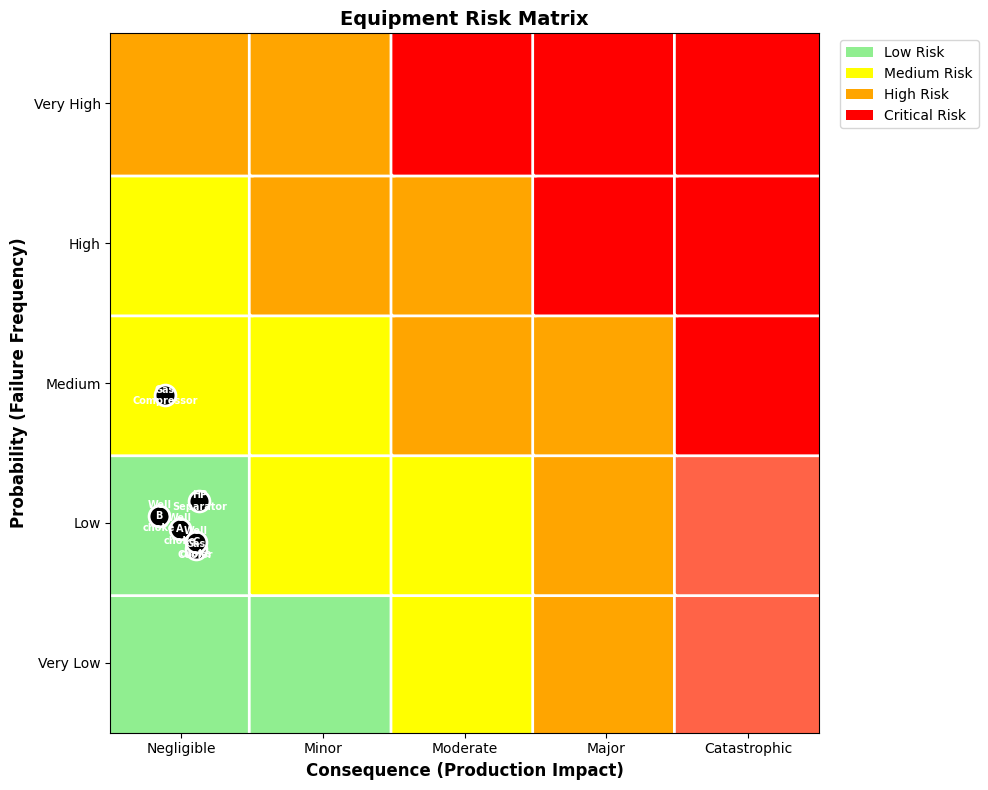


Risk matrix saved to 'risk_matrix.png'


In [7]:
# Visualize Risk Matrix
def plot_risk_matrix(assessments):
    """Plot 5x5 risk matrix with equipment positions."""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Risk matrix colors (5x5)
    colors = [
        ['#90EE90', '#90EE90', '#FFFF00', '#FFA500', '#FF6347'],  # Row 1 (Low prob)
        ['#90EE90', '#FFFF00', '#FFFF00', '#FFA500', '#FF6347'],  # Row 2
        ['#FFFF00', '#FFFF00', '#FFA500', '#FFA500', '#FF0000'],  # Row 3
        ['#FFFF00', '#FFA500', '#FFA500', '#FF0000', '#FF0000'],  # Row 4
        ['#FFA500', '#FFA500', '#FF0000', '#FF0000', '#FF0000'],  # Row 5 (High prob)
    ]
    
    # Draw risk matrix grid
    for i in range(5):
        for j in range(5):
            rect = FancyBboxPatch((j, i), 1, 1, boxstyle="round,pad=0.02",
                                   facecolor=colors[i][j], edgecolor='white', linewidth=2)
            ax.add_patch(rect)
    
    # Map categories to positions
    prob_map = {'VERY_LOW': 0.5, 'LOW': 1.5, 'MEDIUM': 2.5, 'HIGH': 3.5, 'VERY_HIGH': 4.5}
    cons_map = {'NEGLIGIBLE': 0.5, 'MINOR': 1.5, 'MODERATE': 2.5, 'MAJOR': 3.5, 'CATASTROPHIC': 4.5}
    
    # Plot equipment points
    for a in assessments:
        prob_cat = a['prob_category'].split('.')[-1] if '.' in a['prob_category'] else a['prob_category']
        cons_cat = a['cons_category'].split('.')[-1] if '.' in a['cons_category'] else a['cons_category']
        
        x = cons_map.get(cons_cat, 2.5)
        y = prob_map.get(prob_cat, 2.5)
        
        # Add small random offset to avoid overlap
        x += np.random.uniform(-0.2, 0.2)
        y += np.random.uniform(-0.2, 0.2)
        
        ax.plot(x, y, 'ko', markersize=15, markeredgecolor='white', markeredgewidth=2)
        ax.annotate(a['equipment'].replace('_', '\n'), (x, y), 
                   fontsize=7, ha='center', va='center', color='white', fontweight='bold')
    
    # Labels
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
    ax.set_xticklabels(['Negligible', 'Minor', 'Moderate', 'Major', 'Catastrophic'])
    ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
    ax.set_yticklabels(['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    ax.set_xlabel('Consequence (Production Impact)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Probability (Failure Frequency)', fontsize=12, fontweight='bold')
    ax.set_title('Equipment Risk Matrix', fontsize=14, fontweight='bold')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#90EE90', label='Low Risk'),
        Patch(facecolor='#FFFF00', label='Medium Risk'),
        Patch(facecolor='#FFA500', label='High Risk'),
        Patch(facecolor='#FF0000', label='Critical Risk'),
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))
    
    plt.tight_layout()
    plt.savefig('risk_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nRisk matrix saved to 'risk_matrix.png'")

if assessments:
    plot_risk_matrix(assessments)

## 6. Monte Carlo Risk Simulation

Run Monte Carlo simulation to estimate:
- **Production availability** over time
- **P10/P50/P90 production** profiles
- **Downtime distribution**

In [9]:
# Create Operational Risk Simulator
risk_simulator = OperationalRiskSimulator(process)

# Add equipment reliability data
for equip_name, data in reliability_data.items():
    risk_simulator.addEquipmentReliability(equip_name, data['failure_rate'], data['mttr'])

# Set random seed for reproducibility
risk_simulator.setRandomSeed(42)

# Run Monte Carlo simulation
# 1000 iterations, 365 days (1 year)
print("Running Monte Carlo simulation (1000 iterations, 1 year)...")
mc_result = risk_simulator.runSimulation(1000, 365.0)

print("\n" + "=" * 60)
print("MONTE CARLO SIMULATION RESULTS")
print("=" * 60)
print(f"\nProduction Availability: {mc_result.getAvailability():.2f}%")
print(f"Mean Downtime: {mc_result.getMeanDowntimeHours():.1f} hours/year")
print(f"Mean Failure Count: {mc_result.getMeanFailureCount():.1f} per year")
print(f"\nProduction Forecast (kg/year):")
print(f"  P10 (Pessimistic): {mc_result.getP10Production():,.0f}")
print(f"  P50 (Expected):    {mc_result.getP50Production():,.0f}")
print(f"  P90 (Optimistic):  {mc_result.getP90Production():,.0f}")
print(f"\nExpected Production Loss: {mc_result.getExpectedProductionLoss():,.0f} kg/year")

Running Monte Carlo simulation (1000 iterations, 1 year)...

MONTE CARLO SIMULATION RESULTS

Production Availability: 99.44%
Mean Downtime: 49.1 hours/year
Mean Failure Count: 1.7 per year

Production Forecast (kg/year):
  P10 (Pessimistic): 70,080,000
  P50 (Expected):    70,080,000
  P90 (Optimistic):  70,080,000

Expected Production Loss: -3,368 kg/year


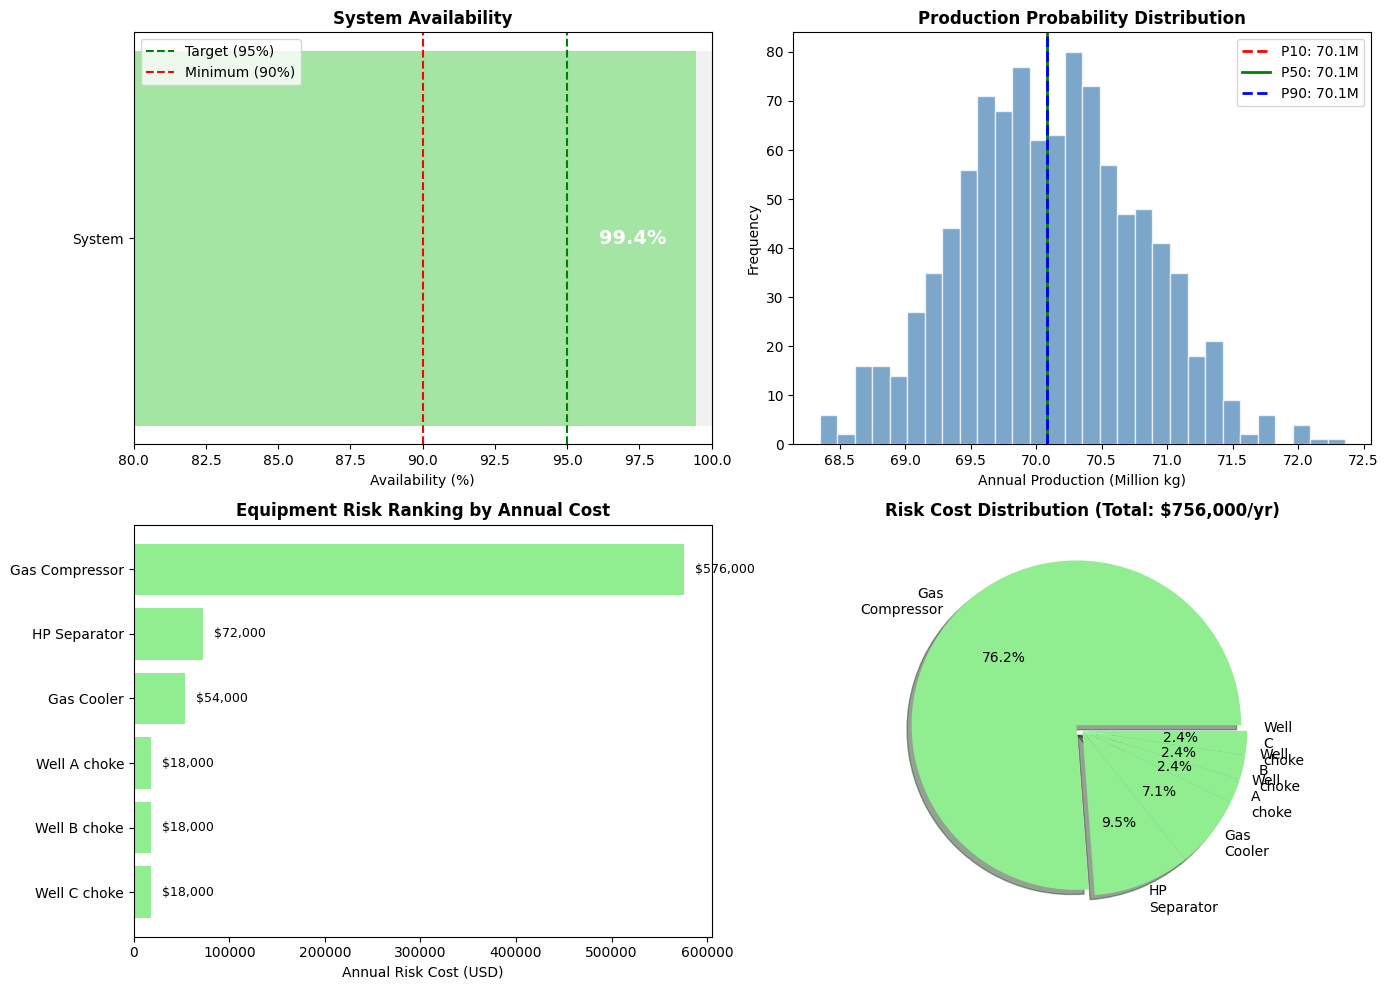


Results saved to 'monte_carlo_results.png'


In [11]:
# Visualize Monte Carlo Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Availability gauge
ax1 = axes[0, 0]
availability = mc_result.getAvailability()
colors = ['#FF6347' if availability < 90 else '#FFA500' if availability < 95 else '#90EE90']
ax1.barh(['System'], [availability], color=colors, height=0.5)
ax1.barh(['System'], [100], color='lightgray', height=0.5, alpha=0.3)
ax1.set_xlim(80, 100)
ax1.set_xlabel('Availability (%)')
ax1.set_title('System Availability', fontweight='bold')
ax1.axvline(x=95, color='green', linestyle='--', label='Target (95%)')
ax1.axvline(x=90, color='red', linestyle='--', label='Minimum (90%)')
ax1.legend()
ax1.text(availability - 1, 0, f'{availability:.1f}%', va='center', ha='right', 
         fontsize=14, fontweight='bold', color='white')

# 2. Production distribution
ax2 = axes[0, 1]
p10 = mc_result.getP10Production()
p50 = mc_result.getP50Production()
p90 = mc_result.getP90Production()

# Handle case where all percentiles are the same
if p90 > p10:
    std_prod = (p90 - p10) / 3.29
else:
    std_prod = p50 * 0.02  # Use 2% of mean as default spread

production_samples = np.random.normal(p50, max(std_prod, p50*0.01), 1000)
ax2.hist(production_samples / 1e6, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
ax2.axvline(p10/1e6, color='red', linestyle='--', linewidth=2, label=f'P10: {p10/1e6:.1f}M')
ax2.axvline(p50/1e6, color='green', linestyle='-', linewidth=2, label=f'P50: {p50/1e6:.1f}M')
ax2.axvline(p90/1e6, color='blue', linestyle='--', linewidth=2, label=f'P90: {p90/1e6:.1f}M')
ax2.set_xlabel('Annual Production (Million kg)')
ax2.set_ylabel('Frequency')
ax2.set_title('Production Probability Distribution', fontweight='bold')
ax2.legend()

# 3. Equipment risk ranking
ax3 = axes[1, 0]
if assessments:
    sorted_assess = sorted(assessments, key=lambda x: x['annual_cost'], reverse=True)
    equip_names = [a['equipment'].replace('_', ' ') for a in sorted_assess]
    annual_costs = [a['annual_cost'] for a in sorted_assess]
    risk_colors = ['#FF6347' if a['risk_score'] >= 10 else '#FFA500' if a['risk_score'] >= 5 else '#90EE90' 
                   for a in sorted_assess]
    bars = ax3.barh(equip_names, annual_costs, color=risk_colors)
    ax3.set_xlabel('Annual Risk Cost (USD)')
    ax3.set_title('Equipment Risk Ranking by Annual Cost', fontweight='bold')
    ax3.invert_yaxis()
    # Add cost labels
    for bar, cost in zip(bars, annual_costs):
        ax3.text(bar.get_width() + max(annual_costs)*0.02, bar.get_y() + bar.get_height()/2,
                f'${cost:,.0f}', va='center', fontsize=9)

# 4. Risk contribution pie
ax4 = axes[1, 1]
if assessments:
    total_cost = sum(a['annual_cost'] for a in assessments)
    if total_cost > 0:
        sizes = [a['annual_cost']/total_cost * 100 for a in sorted_assess]
        labels = [a['equipment'].replace('_', '\n') for a in sorted_assess]
        explode = [0.05 if s == max(sizes) else 0 for s in sizes]
        ax4.pie(sizes, labels=labels, autopct='%1.1f%%', colors=risk_colors,
               explode=explode, shadow=True)
        ax4.set_title(f'Risk Cost Distribution (Total: ${total_cost:,.0f}/yr)', fontweight='bold')

plt.tight_layout()
plt.savefig('monte_carlo_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nResults saved to 'monte_carlo_results.png'")

## 7. Well Prioritization Under Risk

Analyze which wells to prioritize considering:
- **Production capacity** (throughput)
- **Equipment stress** (compressor load, separator capacity)
- **Risk impact** (failure consequences)

In [12]:
def evaluate_well_scenario(active_wells, well_rates_base):
    """
    Evaluate a production scenario with specific wells active.
    Returns production metrics and risk assessment.
    """
    # Build rates for active wells
    rates = {w: well_rates_base[w] if w in active_wells else 0 
             for w in well_rates_base}
    
    total_rate = sum(rates.values())
    if total_rate == 0:
        return None
    
    # Build and run process
    proc, equip = build_production_system(rates)
    if proc is None:
        return None
    
    # Get performance
    perf = analyze_system_performance(proc, equip)
    
    # Run quick Monte Carlo
    sim = OperationalRiskSimulator(proc)
    for en, data in reliability_data.items():
        sim.addEquipmentReliability(en, data['failure_rate'], data['mttr'])
    sim.setRandomSeed(42)
    result = sim.runSimulation(500, 365.0)  # Quick simulation
    
    return {
        'wells': list(active_wells),
        'total_rate': total_rate,
        'gas_rate': perf['gas_rate_kg_hr'],
        'oil_rate': perf['oil_rate_kg_hr'],
        'compressor_power': perf['compressor_power_kW'],
        'availability': result.getAvailability(),
        'expected_production': result.getP50Production(),
        'production_loss': result.getExpectedProductionLoss(),
    }

# Evaluate different well combinations
from itertools import combinations

all_wells = ['Well_A', 'Well_B', 'Well_C']
base_rates = {'Well_A': 15000.0, 'Well_B': 12000.0, 'Well_C': 8000.0}

scenarios = []
print("Evaluating Well Scenarios...")
print("=" * 70)

# All combinations of 1, 2, 3 wells
for r in range(1, len(all_wells) + 1):
    for combo in combinations(all_wells, r):
        result = evaluate_well_scenario(combo, base_rates)
        if result:
            scenarios.append(result)
            wells_str = ' + '.join([w.replace('Well_', '') for w in result['wells']])
            print(f"{wells_str:12} | Rate: {result['total_rate']:>7.0f} kg/hr | "
                  f"Availability: {result['availability']:.1f}% | "
                  f"Comp Power: {result['compressor_power']:.0f} kW")

Evaluating Well Scenarios...
A            | Rate:   15000 kg/hr | Availability: 99.5% | Comp Power: 65 kW
B            | Rate:   12000 kg/hr | Availability: 99.5% | Comp Power: 265 kW
C            | Rate:    8000 kg/hr | Availability: 99.5% | Comp Power: 80 kW
A + B        | Rate:   27000 kg/hr | Availability: 99.5% | Comp Power: 328 kW
A + C        | Rate:   23000 kg/hr | Availability: 99.5% | Comp Power: 145 kW
B + C        | Rate:   20000 kg/hr | Availability: 99.5% | Comp Power: 345 kW
A + B + C    | Rate:   35000 kg/hr | Availability: 99.5% | Comp Power: 409 kW


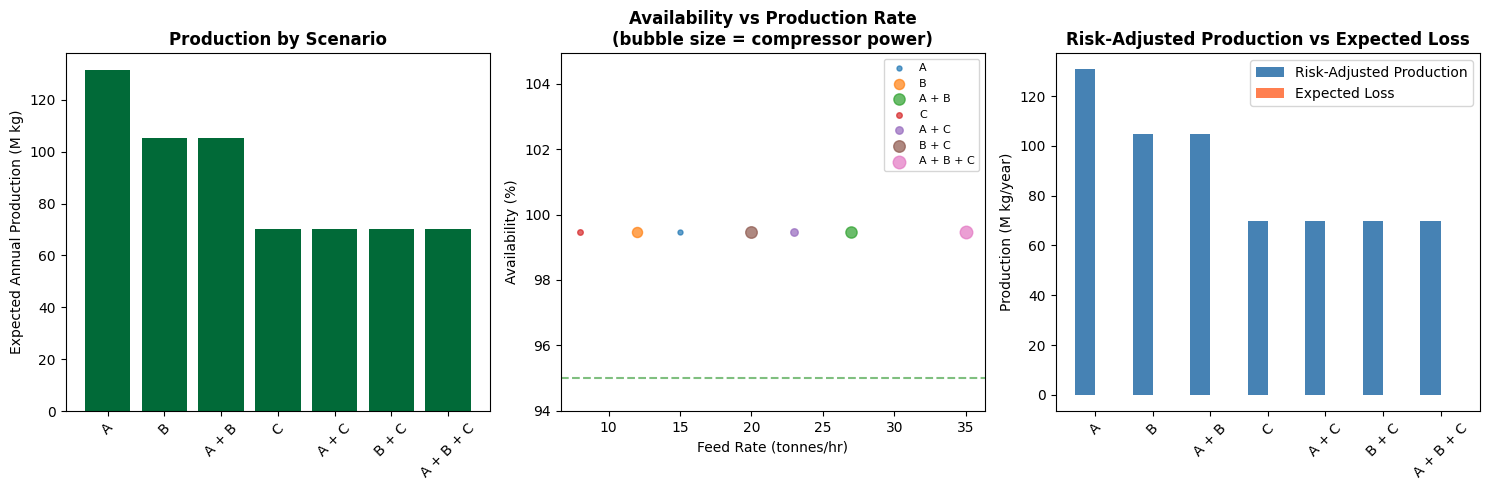


Well prioritization analysis saved to 'well_prioritization_risk.png'


In [13]:
# Visualize well prioritization analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sort scenarios
scenarios_sorted = sorted(scenarios, key=lambda x: x['expected_production'], reverse=True)

# Scenario labels
labels = [' + '.join([w.replace('Well_', '') for w in s['wells']]) for s in scenarios_sorted]

# 1. Expected Production
ax1 = axes[0]
prods = [s['expected_production']/1e6 for s in scenarios_sorted]
colors = plt.cm.RdYlGn([s['availability']/100 for s in scenarios_sorted])
bars = ax1.bar(labels, prods, color=colors)
ax1.set_ylabel('Expected Annual Production (M kg)')
ax1.set_title('Production by Scenario', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# 2. Availability vs Production Rate
ax2 = axes[1]
for s in scenarios_sorted:
    wells_str = ' + '.join([w.replace('Well_', '') for w in s['wells']])
    ax2.scatter(s['total_rate']/1000, s['availability'], 
               s=s['compressor_power']/5, alpha=0.7,
               label=wells_str)
ax2.set_xlabel('Feed Rate (tonnes/hr)')
ax2.set_ylabel('Availability (%)')
ax2.set_title('Availability vs Production Rate\n(bubble size = compressor power)', fontweight='bold')
ax2.legend(fontsize=8)
ax2.axhline(y=95, color='green', linestyle='--', alpha=0.5)

# 3. Risk-adjusted production
ax3 = axes[2]
# Calculate risk-adjusted production = expected_production * (availability/100)
risk_adj_prod = [s['expected_production'] * s['availability'] / 100 / 1e6 for s in scenarios_sorted]
prod_loss = [s['production_loss']/1e6 for s in scenarios_sorted]

x = np.arange(len(labels))
width = 0.35
ax3.bar(x - width/2, risk_adj_prod, width, label='Risk-Adjusted Production', color='steelblue')
ax3.bar(x + width/2, prod_loss, width, label='Expected Loss', color='coral')
ax3.set_xticks(x)
ax3.set_xticklabels(labels, rotation=45)
ax3.set_ylabel('Production (M kg/year)')
ax3.set_title('Risk-Adjusted Production vs Expected Loss', fontweight='bold')
ax3.legend()

plt.tight_layout()
plt.savefig('well_prioritization_risk.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nWell prioritization analysis saved to 'well_prioritization_risk.png'")

## 8. Operational Recommendations

Generate actionable recommendations based on combined bottleneck and risk analysis.

In [14]:
def generate_operational_recommendations(scenarios, assessments, mc_result):
    """Generate operational recommendations from analysis."""
    recommendations = []
    
    # 1. Best production scenario
    best_prod = max(scenarios, key=lambda x: x['expected_production'])
    recommendations.append({
        'category': 'PRODUCTION',
        'priority': 'HIGH',
        'recommendation': f"Optimal production: {' + '.join(best_prod['wells'])} "
                         f"({best_prod['total_rate']:.0f} kg/hr)",
        'benefit': f"Expected: {best_prod['expected_production']/1e6:.1f}M kg/year"
    })
    
    # 2. Best risk-adjusted scenario
    best_risk_adj = max(scenarios, 
                        key=lambda x: x['expected_production'] * x['availability'] / 100)
    if best_risk_adj != best_prod:
        recommendations.append({
            'category': 'RISK-ADJUSTED',
            'priority': 'MEDIUM',
            'recommendation': f"Risk-optimized: {' + '.join(best_risk_adj['wells'])} "
                             f"({best_risk_adj['availability']:.1f}% availability)",
            'benefit': f"Lower downtime, more stable production"
        })
    
    # 3. Equipment-specific recommendations
    if assessments:
        high_risk = [a for a in assessments if a['risk_score'] >= 10]
        for a in high_risk:
            recommendations.append({
                'category': 'MAINTENANCE',
                'priority': 'CRITICAL',
                'recommendation': f"Improve reliability of {a['equipment']} "
                                 f"(current: {a['failure_rate']:.1f} failures/yr)",
                'benefit': f"Reduce annual risk cost of ${a['annual_cost']:,.0f}"
            })
    
    # 4. Availability improvement
    availability = mc_result.getAvailability()
    if availability < 95:
        recommendations.append({
            'category': 'AVAILABILITY',
            'priority': 'HIGH',
            'recommendation': f"Improve system availability from {availability:.1f}% to 95%+ target",
            'benefit': f"Reduce expected production loss of {mc_result.getExpectedProductionLoss()/1e6:.1f}M kg/year"
        })
    
    return recommendations

recommendations = generate_operational_recommendations(scenarios, assessments, mc_result)

print("\n" + "=" * 70)
print("OPERATIONAL RECOMMENDATIONS")
print("=" * 70)

for i, rec in enumerate(recommendations, 1):
    priority_colors = {'CRITICAL': '🔴', 'HIGH': '🟠', 'MEDIUM': '🟡', 'LOW': '🟢'}
    icon = priority_colors.get(rec['priority'], '⚪')
    print(f"\n{icon} [{rec['category']}] {rec['priority']}")
    print(f"   → {rec['recommendation']}")
    print(f"   💰 {rec['benefit']}")


OPERATIONAL RECOMMENDATIONS

🟠 [PRODUCTION] HIGH
   → Optimal production: Well_A (15000 kg/hr)
   💰 Expected: 131.4M kg/year


## 9. Summary Dashboard

Create a comprehensive summary of the integrated analysis.

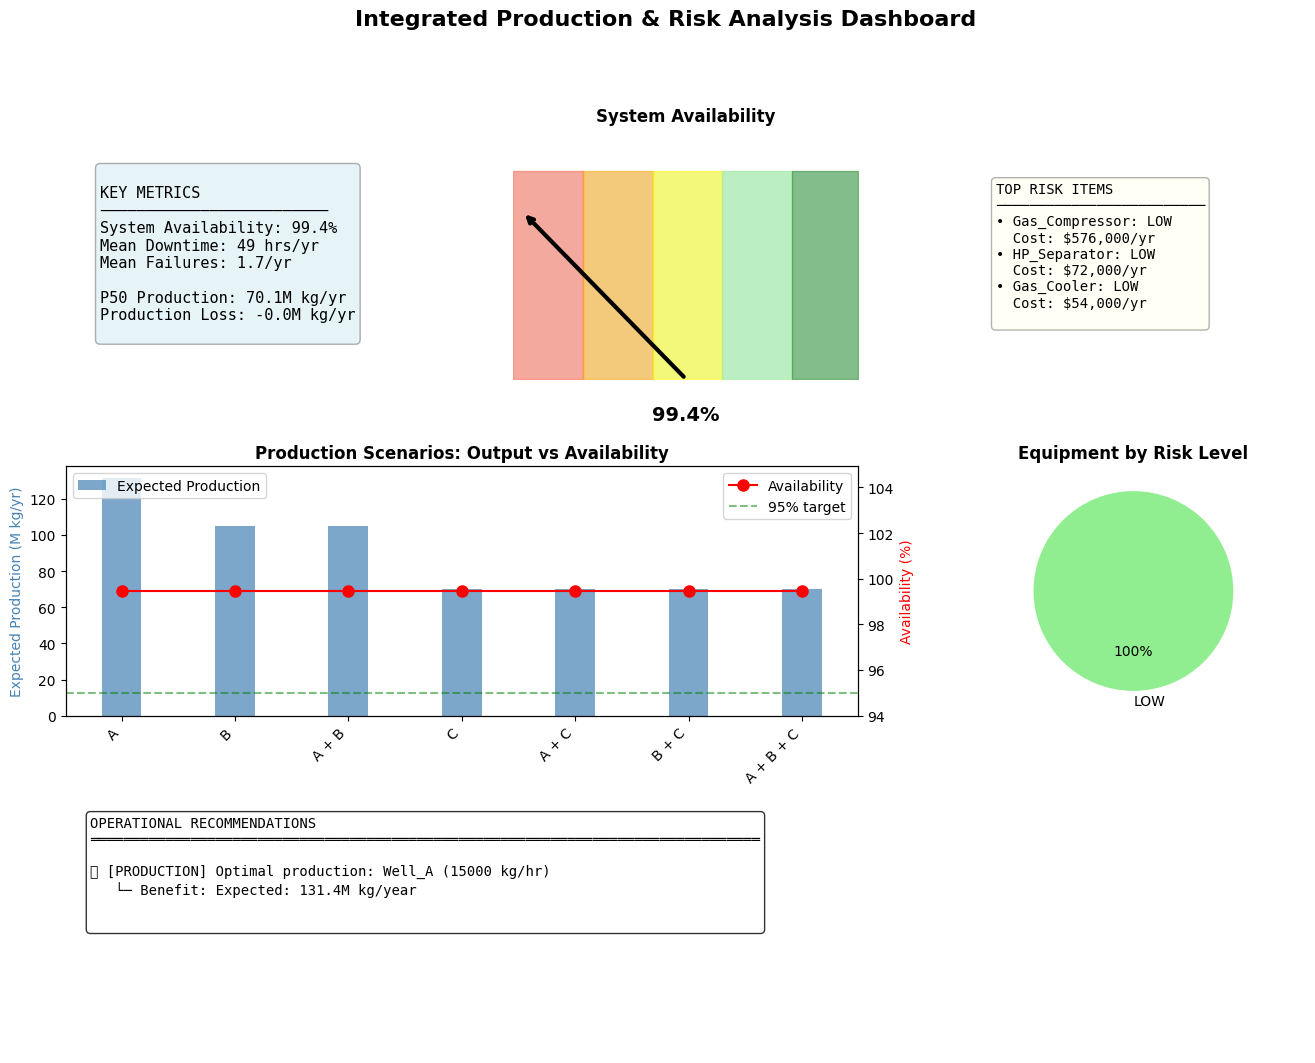


✓ Dashboard saved to 'integrated_dashboard.png'


In [16]:
# Create summary dashboard
fig = plt.figure(figsize=(16, 12))

# Title
fig.suptitle('Integrated Production & Risk Analysis Dashboard', fontsize=16, fontweight='bold', y=0.98)

# Layout: 3x3 grid
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Key Metrics (top-left)
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')
metrics_text = f"""
KEY METRICS
─────────────────────────
System Availability: {mc_result.getAvailability():.1f}%
Mean Downtime: {mc_result.getMeanDowntimeHours():.0f} hrs/yr
Mean Failures: {mc_result.getMeanFailureCount():.1f}/yr

P50 Production: {mc_result.getP50Production()/1e6:.1f}M kg/yr
Production Loss: {mc_result.getExpectedProductionLoss()/1e6:.1f}M kg/yr
"""
ax1.text(0.1, 0.5, metrics_text, fontsize=11, fontfamily='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# 2. Availability gauge (top-middle)
ax2 = fig.add_subplot(gs[0, 1])
availability = mc_result.getAvailability()
theta = np.linspace(0, np.pi, 100)
ax2.fill_between(theta, 0, 1, alpha=0.1)
colors_gauge = ['#FF6347', '#FFA500', '#FFFF00', '#90EE90', '#228B22']
for i, (start, end) in enumerate([(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]):
    ax2.fill_between(theta[int(start*100):int(end*100)+1], 0, 1, 
                     color=colors_gauge[i], alpha=0.5)
# Pointer
avail_norm = (availability - 80) / 20  # Normalize to 80-100% range
avail_norm = max(0, min(1, avail_norm))
pointer_angle = np.pi * (1 - avail_norm)
ax2.annotate('', xy=(pointer_angle, 0.8), xytext=(np.pi/2, 0),
             arrowprops=dict(arrowstyle='->', lw=3, color='black'))
ax2.set_xlim(0, np.pi)
ax2.set_ylim(0, 1.2)
ax2.axis('off')
ax2.text(np.pi/2, -0.2, f'{availability:.1f}%', ha='center', fontsize=14, fontweight='bold')
ax2.set_title('System Availability', fontweight='bold')

# 3. Top risks (top-right)
ax3 = fig.add_subplot(gs[0, 2])
ax3.axis('off')
risk_text = "TOP RISK ITEMS\n" + "─" * 25 + "\n"
if assessments:
    for a in sorted(assessments, key=lambda x: x['risk_score'], reverse=True)[:3]:
        risk_text += f"• {a['equipment']}: {a['risk_level']}\n"
        risk_text += f"  Cost: ${a['annual_cost']:,.0f}/yr\n"
ax3.text(0.1, 0.5, risk_text, fontsize=10, fontfamily='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))

# 4. Production scenarios (middle row, spans 2 columns)
ax4 = fig.add_subplot(gs[1, :2])
scenarios_sorted = sorted(scenarios, key=lambda x: x['expected_production'], reverse=True)
labels = [' + '.join([w.replace('Well_', '') for w in s['wells']]) for s in scenarios_sorted]
prods = [s['expected_production']/1e6 for s in scenarios_sorted]
avails = [s['availability'] for s in scenarios_sorted]

x = np.arange(len(labels))
width = 0.35
ax4_twin = ax4.twinx()

bars = ax4.bar(x, prods, width, label='Expected Production', color='steelblue', alpha=0.7)
ax4_twin.plot(x, avails, 'ro-', label='Availability', markersize=8)
ax4_twin.axhline(y=95, color='green', linestyle='--', alpha=0.5, label='95% target')

ax4.set_xticks(x)
ax4.set_xticklabels(labels, rotation=45, ha='right')
ax4.set_ylabel('Expected Production (M kg/yr)', color='steelblue')
ax4_twin.set_ylabel('Availability (%)', color='red')
ax4.set_title('Production Scenarios: Output vs Availability', fontweight='bold')
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')

# 5. Risk breakdown (middle-right)
ax5 = fig.add_subplot(gs[1, 2])
if assessments:
    risk_levels = {}
    for a in assessments:
        level = a['risk_level']
        risk_levels[level] = risk_levels.get(level, 0) + 1
    level_colors = {'LOW': '#90EE90', 'MEDIUM': '#FFFF00', 'HIGH': '#FFA500', 'CRITICAL': '#FF6347'}
    labels_risk = list(risk_levels.keys())
    sizes = list(risk_levels.values())
    colors_pie = [level_colors.get(l, 'gray') for l in labels_risk]
    ax5.pie(sizes, labels=labels_risk, colors=colors_pie, autopct='%1.0f%%', startangle=90)
    ax5.set_title('Equipment by Risk Level', fontweight='bold')

# 6. Recommendations (bottom row, spans all columns)
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')
rec_text = "OPERATIONAL RECOMMENDATIONS\n" + "═" * 80 + "\n\n"
for rec in recommendations[:4]:
    priority_icons = {'CRITICAL': '🔴', 'HIGH': '🟠', 'MEDIUM': '🟡', 'LOW': '🟢'}
    icon = priority_icons.get(rec['priority'], '⚪')
    rec_text += f"{icon} [{rec['category']}] {rec['recommendation']}\n"
    rec_text += f"   └─ Benefit: {rec['benefit']}\n\n"

ax6.text(0.02, 0.95, rec_text, fontsize=10, fontfamily='monospace',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.savefig('integrated_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("\n✓ Dashboard saved to 'integrated_dashboard.png'")

## 10. Real-Time Monitoring Dashboard

This section demonstrates how to integrate **live streaming data** with the operational dashboard. We simulate sensor data arriving in real-time and show how the dashboard updates dynamically.

### Use Cases for Real-Time Monitoring

| Application | Data Source | Update Frequency |
|-------------|-------------|------------------|
| Process Control | DCS/SCADA sensors | 1-10 seconds |
| Production Monitoring | Flow meters, separators | 1-5 minutes |
| Equipment Health | Vibration, temperature | 10-60 seconds |
| Risk Assessment | Alarm systems, trip counters | Event-driven |

### Simulated Data Stream

We'll simulate:
1. **Well flow rates** fluctuating with noise
2. **Equipment sensors** (pressure, temperature)
3. **Alarm events** triggering risk updates
4. **Production totals** accumulating over time

In [23]:
import time
from datetime import datetime, timedelta
from IPython.display import display, clear_output
import random

class RealTimeDataSimulator:
    """
    Simulates real-time sensor data from a production system.
    In production, this would connect to OPC-UA, PI, or SCADA systems.
    """
    
    def __init__(self, base_rates, equipment_list):
        self.base_rates = base_rates
        self.equipment_list = equipment_list
        self.start_time = datetime.now()
        self.cumulative_production = 0.0
        self.alarm_history = []
        self.current_alarms = []
        
        # Sensor noise parameters
        self.noise_std = 0.05  # 5% standard deviation
        
        # Equipment status (True = running, False = tripped)
        self.equipment_status = {eq: True for eq in equipment_list}
        
        # Trip probabilities per time step (based on failure rates)
        self.trip_probs = {
            'Gas_Compressor': 0.001,    # ~0.1% per interval
            'HP_Separator': 0.0002,
            'Gas_Cooler': 0.0003,
            'Well_A_choke': 0.0002,
            'Well_B_choke': 0.0002,
            'Well_C_choke': 0.0002,
        }
        
        # Recovery times (seconds in simulation)
        self.recovery_times = {
            'Gas_Compressor': 30,
            'HP_Separator': 20,
            'Gas_Cooler': 10,
            'Well_A_choke': 8,
            'Well_B_choke': 8,
            'Well_C_choke': 8,
        }
        self.trip_remaining = {eq: 0 for eq in equipment_list}
        self.total_downtime_minutes = 0
    
    def get_sensor_reading(self, timestamp_idx):
        """
        Generate simulated sensor readings for current time step.
        
        Returns dict with all sensor values and system status.
        """
        readings = {
            'timestamp': self.start_time + timedelta(minutes=timestamp_idx),
            'wells': {},
            'equipment': {},
            'alarms': [],
            'production': {},
        }
        
        # Simulate equipment trips and recovery
        for eq in self.equipment_list:
            if self.trip_remaining[eq] > 0:
                self.trip_remaining[eq] -= 1
                if self.trip_remaining[eq] == 0:
                    self.equipment_status[eq] = True
                    readings['alarms'].append(f"{eq} RECOVERED")
            elif self.equipment_status[eq] and random.random() < self.trip_probs.get(eq, 0):
                self.equipment_status[eq] = False
                self.trip_remaining[eq] = self.recovery_times.get(eq, 10)
                readings['alarms'].append(f"{eq} TRIPPED!")
                self.alarm_history.append({
                    'time': readings['timestamp'],
                    'equipment': eq,
                    'type': 'TRIP'
                })
        
        # Well flow rates with noise and choke status
        system_running = self.equipment_status.get('HP_Separator', True) and \
                        self.equipment_status.get('Gas_Compressor', True)
        
        # Track downtime
        if not system_running:
            self.total_downtime_minutes += 1
        
        for well, base_rate in self.base_rates.items():
            choke_name = f"{well}_choke"
            choke_ok = self.equipment_status.get(choke_name, True)
            
            if system_running and choke_ok:
                # Add realistic noise (±5%)
                noise = random.gauss(0, self.noise_std)
                rate = base_rate * (1 + noise)
                # Add slight trend (production decline simulation)
                decline = 1 - (timestamp_idx * 0.0001)  # 0.01% per step
                rate *= max(0.9, decline)
            else:
                rate = 0.0
            
            readings['wells'][well] = {
                'flow_rate_kg_hr': rate,
                'status': 'ONLINE' if (choke_ok and rate > 0) else 'OFFLINE',
                'wellhead_pressure_bara': 75 + random.gauss(0, 2) if rate > 0 else 0,
                'wellhead_temp_C': 85 + random.gauss(0, 1) if rate > 0 else 20,
            }
        
        # Equipment sensors
        total_flow = sum(w['flow_rate_kg_hr'] for w in readings['wells'].values())
        
        readings['equipment']['HP_Separator'] = {
            'status': 'RUNNING' if self.equipment_status['HP_Separator'] else 'TRIPPED',
            'pressure_bara': 25 + random.gauss(0, 0.5) if system_running else 0,
            'temperature_C': 65 + random.gauss(0, 1) if system_running else 20,
            'level_percent': 45 + random.gauss(0, 3) if system_running else 0,
        }
        
        comp_running = system_running and self.equipment_status['Gas_Compressor']
        readings['equipment']['Gas_Compressor'] = {
            'status': 'RUNNING' if self.equipment_status['Gas_Compressor'] else 'TRIPPED',
            'power_kW': 850 + random.gauss(0, 20) if comp_running else 0,
            'suction_pressure_bara': 25 if comp_running else 0,
            'discharge_pressure_bara': 80 + random.gauss(0, 1) if comp_running else 0,
            'vibration_mm_s': 2.5 + random.gauss(0, 0.3) if comp_running else 0,
        }
        
        cooler_running = comp_running and self.equipment_status['Gas_Cooler']
        readings['equipment']['Gas_Cooler'] = {
            'status': 'RUNNING' if self.equipment_status['Gas_Cooler'] else 'TRIPPED',
            'duty_kW': 450 + random.gauss(0, 15) if cooler_running else 0,
            'outlet_temp_C': 35 + random.gauss(0, 0.5) if cooler_running else 20,
        }
        
        # Production totals
        production_rate = total_flow if system_running else 0
        self.cumulative_production += production_rate / 60  # kg per minute
        
        # Calculate uptime percentage
        if timestamp_idx > 0:
            uptime_pct = ((timestamp_idx - self.total_downtime_minutes) / timestamp_idx) * 100
        else:
            uptime_pct = 100.0
        
        readings['production'] = {
            'current_rate_kg_hr': production_rate,
            'current_rate_percent': production_rate / sum(self.base_rates.values()) * 100,
            'cumulative_kg': self.cumulative_production,
            'cumulative_tonnes': self.cumulative_production / 1000,
            'uptime_percent': uptime_pct,
        }
        
        self.current_alarms = readings['alarms']
        return readings


# Initialize simulator
equipment_list = ['Gas_Compressor', 'HP_Separator', 'Gas_Cooler', 
                  'Well_A_choke', 'Well_B_choke', 'Well_C_choke']
simulator = RealTimeDataSimulator(base_rates, equipment_list)

print("Real-Time Data Simulator initialized!")
print(f"Monitoring {len(equipment_list)} equipment items")
print(f"Tracking {len(base_rates)} wells")
print(f"\nBase production rate: {sum(base_rates.values()):,.0f} kg/hr")

Real-Time Data Simulator initialized!
Monitoring 6 equipment items
Tracking 3 wells

Base production rate: 35,000 kg/hr


### Live Dashboard Visualization

The following cell runs a **simulated real-time monitoring session**. It:
1. Generates sensor data every iteration (simulating 1-minute intervals)
2. Updates dashboard with current readings
3. Shows alarm events as they occur
4. Tracks cumulative production and system uptime

**Note**: In production, replace the simulator with actual data sources (OPC-UA, REST API, message queue, etc.)

In [24]:
def create_realtime_dashboard(readings, history_data):
    """
    Create a real-time monitoring dashboard with current readings.
    
    Args:
        readings: Current sensor readings dict
        history_data: Historical data for trends
    """
    fig = plt.figure(figsize=(18, 12))
    fig.suptitle(f"🔴 LIVE Production Monitoring Dashboard\n{readings['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}", 
                 fontsize=16, fontweight='bold', color='darkblue')
    
    gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)
    
    # === Row 1: Well Status and Rates ===
    
    # 1. Well Status Panel
    ax_wells = fig.add_subplot(gs[0, 0])
    ax_wells.axis('off')
    well_text = "WELL STATUS\n" + "─" * 20 + "\n"
    for well, data in readings['wells'].items():
        status_icon = "🟢" if data['status'] == 'ONLINE' else "🔴"
        well_text += f"\n{status_icon} {well}\n"
        well_text += f"   Rate: {data['flow_rate_kg_hr']:,.0f} kg/hr\n"
        well_text += f"   WHP: {data['wellhead_pressure_bara']:.1f} bara\n"
    ax_wells.text(0.05, 0.95, well_text, fontsize=9, fontfamily='monospace',
                  verticalalignment='top', transform=ax_wells.transAxes,
                  bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray'))
    
    # 2. Production Rate Trend
    ax_trend = fig.add_subplot(gs[0, 1:3])
    times = [h['timestamp'] for h in history_data]
    rates = [h['production']['current_rate_kg_hr'] for h in history_data]
    ax_trend.plot(range(len(rates)), rates, 'b-', linewidth=2, label='Actual')
    ax_trend.axhline(y=sum(base_rates.values()), color='green', linestyle='--', 
                     alpha=0.7, label='Design Rate')
    ax_trend.fill_between(range(len(rates)), rates, alpha=0.3)
    ax_trend.set_ylabel('Production Rate (kg/hr)')
    ax_trend.set_xlabel('Time (minutes)')
    ax_trend.set_title('Production Rate Trend', fontweight='bold')
    ax_trend.legend(loc='upper right')
    ax_trend.set_ylim(0, sum(base_rates.values()) * 1.2)
    ax_trend.grid(True, alpha=0.3)
    
    # 3. Current Production KPIs
    ax_kpi = fig.add_subplot(gs[0, 3])
    ax_kpi.axis('off')
    prod = readings['production']
    rate_color = '#00AA00' if prod['current_rate_percent'] > 90 else '#FFA500' if prod['current_rate_percent'] > 70 else '#FF0000'
    kpi_text = f"""
PRODUCTION KPIs
─────────────────────
Current Rate:
  {prod['current_rate_kg_hr']:,.0f} kg/hr
  ({prod['current_rate_percent']:.1f}% of design)

Cumulative:
  {prod['cumulative_tonnes']:,.1f} tonnes

System Uptime:
  {prod['uptime_percent']:.1f}%
"""
    ax_kpi.text(0.1, 0.9, kpi_text, fontsize=10, fontfamily='monospace',
                verticalalignment='top', transform=ax_kpi.transAxes,
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    
    # === Row 2: Equipment Status ===
    
    # 4. Separator Status
    ax_sep = fig.add_subplot(gs[1, 0])
    sep_data = readings['equipment']['HP_Separator']
    status_color = '#00AA00' if sep_data['status'] == 'RUNNING' else '#FF0000'
    ax_sep.add_patch(plt.Circle((0.5, 0.5), 0.3, color=status_color, alpha=0.3))
    ax_sep.text(0.5, 0.85, 'HP SEPARATOR', ha='center', fontweight='bold', fontsize=10)
    ax_sep.text(0.5, 0.5, sep_data['status'], ha='center', fontsize=12, fontweight='bold',
               color=status_color)
    ax_sep.text(0.5, 0.25, f"P: {sep_data['pressure_bara']:.1f} bara\nT: {sep_data['temperature_C']:.1f}°C\nLevel: {sep_data['level_percent']:.0f}%",
               ha='center', fontsize=9)
    ax_sep.set_xlim(0, 1)
    ax_sep.set_ylim(0, 1)
    ax_sep.axis('off')
    
    # 5. Compressor Status with gauges
    ax_comp = fig.add_subplot(gs[1, 1])
    comp_data = readings['equipment']['Gas_Compressor']
    status_color = '#00AA00' if comp_data['status'] == 'RUNNING' else '#FF0000'
    ax_comp.add_patch(plt.Circle((0.5, 0.5), 0.3, color=status_color, alpha=0.3))
    ax_comp.text(0.5, 0.85, 'GAS COMPRESSOR', ha='center', fontweight='bold', fontsize=10)
    ax_comp.text(0.5, 0.5, comp_data['status'], ha='center', fontsize=12, fontweight='bold',
                color=status_color)
    ax_comp.text(0.5, 0.25, f"Power: {comp_data['power_kW']:.0f} kW\nPd: {comp_data['discharge_pressure_bara']:.1f} bara\nVib: {comp_data['vibration_mm_s']:.2f} mm/s",
                ha='center', fontsize=9)
    ax_comp.set_xlim(0, 1)
    ax_comp.set_ylim(0, 1)
    ax_comp.axis('off')
    
    # 6. Cooler Status
    ax_cool = fig.add_subplot(gs[1, 2])
    cool_data = readings['equipment']['Gas_Cooler']
    status_color = '#00AA00' if cool_data['status'] == 'RUNNING' else '#FF0000'
    ax_cool.add_patch(plt.Circle((0.5, 0.5), 0.3, color=status_color, alpha=0.3))
    ax_cool.text(0.5, 0.85, 'GAS COOLER', ha='center', fontweight='bold', fontsize=10)
    ax_cool.text(0.5, 0.5, cool_data['status'], ha='center', fontsize=12, fontweight='bold',
                color=status_color)
    ax_cool.text(0.5, 0.25, f"Duty: {cool_data['duty_kW']:.0f} kW\nT out: {cool_data['outlet_temp_C']:.1f}°C",
                ha='center', fontsize=9)
    ax_cool.set_xlim(0, 1)
    ax_cool.set_ylim(0, 1)
    ax_cool.axis('off')
    
    # 7. Alarm Panel
    ax_alarm = fig.add_subplot(gs[1, 3])
    ax_alarm.axis('off')
    alarm_text = "⚠️ ACTIVE ALARMS\n" + "─" * 20 + "\n"
    
    # Get recent alarms from history
    recent_alarms = []
    for h in history_data[-20:]:  # Last 20 readings
        if h.get('alarms'):
            for a in h['alarms']:
                recent_alarms.append(f"{h['timestamp'].strftime('%H:%M')} {a}")
    
    if recent_alarms:
        for alarm in recent_alarms[-5:]:  # Show last 5
            alarm_text += f"\n🔔 {alarm}"
    else:
        alarm_text += "\n✅ No active alarms"
    
    alarm_bg = '#FFEEEE' if recent_alarms else '#EEFFEE'
    ax_alarm.text(0.05, 0.95, alarm_text, fontsize=9, fontfamily='monospace',
                  verticalalignment='top', transform=ax_alarm.transAxes,
                  bbox=dict(boxstyle='round', facecolor=alarm_bg, edgecolor='gray'))
    
    # === Row 3: Trends and Risk ===
    
    # 8. Compressor Power Trend
    ax_power = fig.add_subplot(gs[2, 0:2])
    powers = [h['equipment']['Gas_Compressor']['power_kW'] for h in history_data]
    ax_power.plot(range(len(powers)), powers, 'r-', linewidth=1.5)
    ax_power.axhline(y=900, color='orange', linestyle='--', label='High Limit')
    ax_power.axhline(y=800, color='green', linestyle='--', label='Design')
    ax_power.fill_between(range(len(powers)), powers, alpha=0.3, color='red')
    ax_power.set_ylabel('Power (kW)')
    ax_power.set_xlabel('Time (minutes)')
    ax_power.set_title('Compressor Power Trend', fontweight='bold')
    ax_power.legend(loc='upper right', fontsize=8)
    ax_power.grid(True, alpha=0.3)
    
    # 9. Cumulative Production
    ax_cum = fig.add_subplot(gs[2, 2:4])
    cum_prod = [h['production']['cumulative_tonnes'] for h in history_data]
    ax_cum.plot(range(len(cum_prod)), cum_prod, 'g-', linewidth=2)
    ax_cum.fill_between(range(len(cum_prod)), cum_prod, alpha=0.3, color='green')
    ax_cum.set_ylabel('Cumulative Production (tonnes)')
    ax_cum.set_xlabel('Time (minutes)')
    ax_cum.set_title('Cumulative Production', fontweight='bold')
    ax_cum.grid(True, alpha=0.3)
    
    # Add target line
    target_rate = sum(base_rates.values()) / 1000 / 60  # tonnes per minute
    target_cum = [target_rate * i for i in range(len(cum_prod))]
    ax_cum.plot(range(len(target_cum)), target_cum, 'b--', alpha=0.5, label='Target')
    ax_cum.legend(loc='upper left')
    
    plt.tight_layout()
    return fig


# Run real-time simulation for 60 time steps with higher trip probability for demonstration
print("Starting real-time monitoring simulation...")
print("=" * 60)
print("Simulating 60 minutes of operation with random equipment trips")
print("Watch for alarms and production changes!")
print("=" * 60)

# Reset simulator with higher trip rates for demonstration
simulator = RealTimeDataSimulator(base_rates, equipment_list)
# Increase trip probabilities to show alarm functionality
simulator.trip_probs = {
    'Gas_Compressor': 0.02,     # 2% per interval - will likely trip
    'HP_Separator': 0.005,
    'Gas_Cooler': 0.01,
    'Well_A_choke': 0.005,
    'Well_B_choke': 0.005,
    'Well_C_choke': 0.005,
}

history = []

# Collect 60 data points
for i in range(60):
    readings = simulator.get_sensor_reading(i)
    history.append(readings)
    
    # Print alarms as they happen
    if readings['alarms']:
        for alarm in readings['alarms']:
            print(f"⚠️  [{readings['timestamp'].strftime('%H:%M')}] {alarm}")

print(f"\n✓ Simulation complete: {len(history)} data points collected")
print(f"  Total alarms: {len(simulator.alarm_history)}")
print(f"  Final production: {history[-1]['production']['cumulative_tonnes']:.1f} tonnes")

Starting real-time monitoring simulation...
Simulating 60 minutes of operation with random equipment trips
Watch for alarms and production changes!
⚠️  [16:48] Gas_Compressor TRIPPED!
⚠️  [17:18] Gas_Compressor RECOVERED

✓ Simulation complete: 60 data points collected
  Total alarms: 1
  Final production: 17.3 tonnes


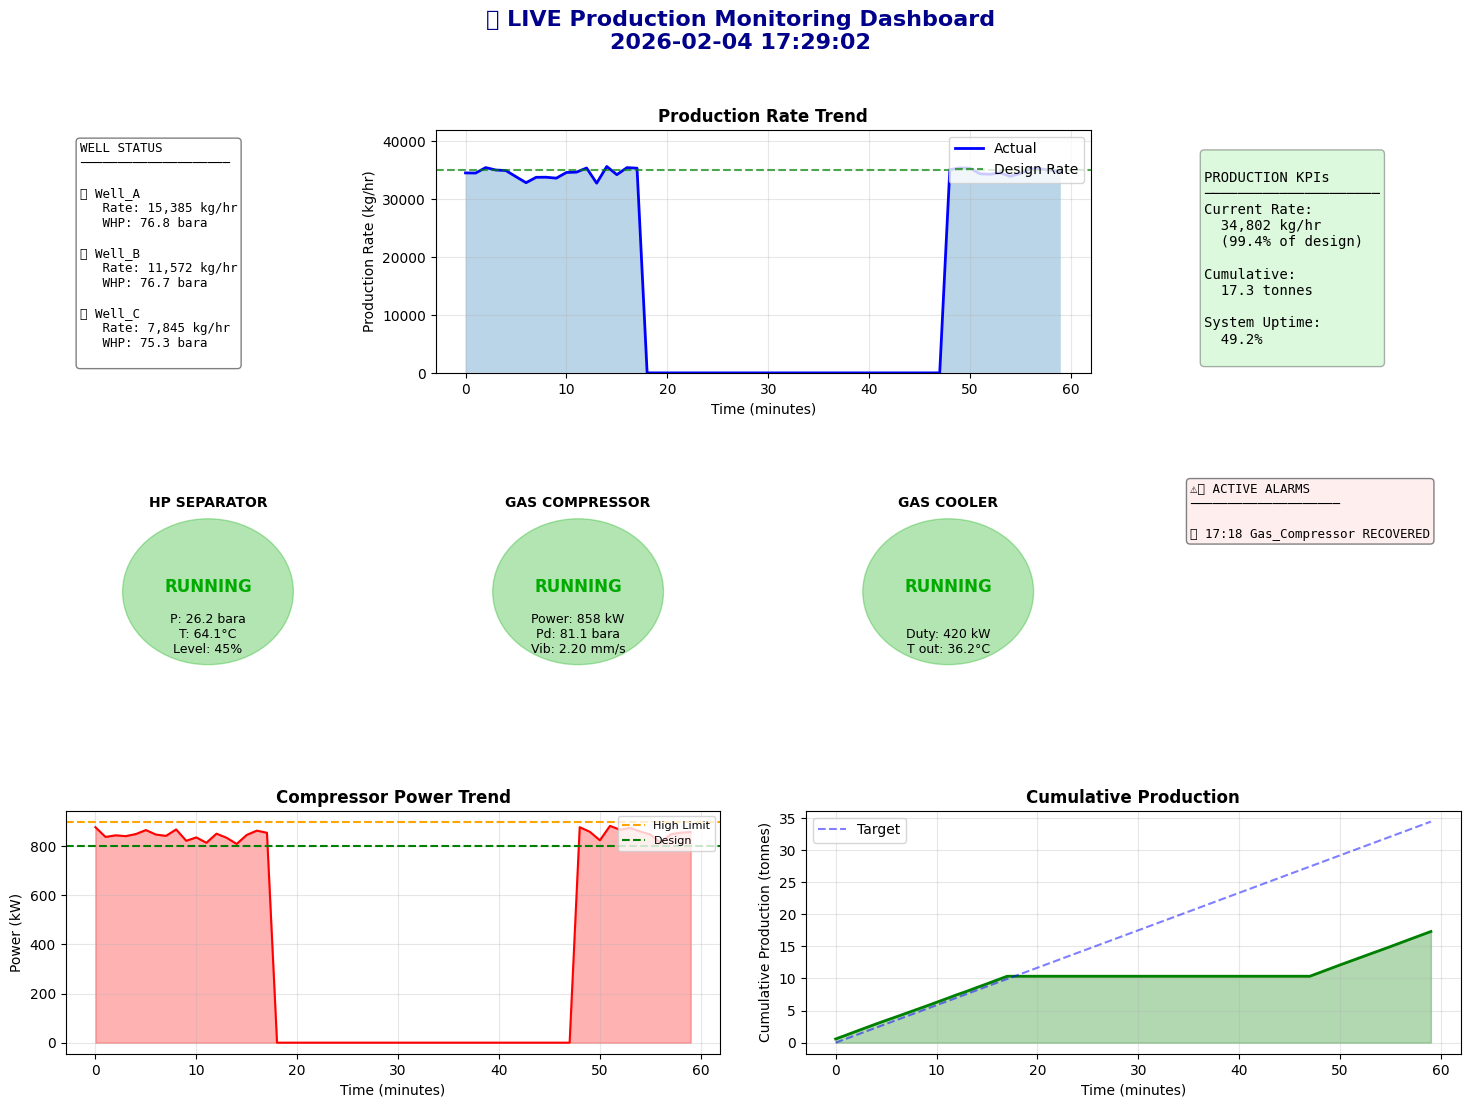


✓ Dashboard snapshot saved to 'realtime_dashboard_snapshot.png'


In [25]:
# Display the final dashboard snapshot
fig = create_realtime_dashboard(history[-1], history)
plt.savefig('realtime_dashboard_snapshot.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("\n✓ Dashboard snapshot saved to 'realtime_dashboard_snapshot.png'")

### Real-Time Risk Update

When equipment trips occur, we can update the risk assessment in real-time using the collected alarm data. This demonstrates how operational events feed back into risk analysis.

In [26]:
def analyze_realtime_risk(history, alarm_history, original_assessments):
    """
    Analyze operational risk based on real-time data.
    Compares actual vs predicted failure rates.
    """
    # Calculate actual metrics from monitoring
    total_minutes = len(history)
    total_hours = total_minutes / 60
    
    # Count trips by equipment
    trip_counts = {}
    for alarm in alarm_history:
        if alarm['type'] == 'TRIP':
            eq = alarm['equipment']
            trip_counts[eq] = trip_counts.get(eq, 0) + 1
    
    # Production statistics
    rates = [h['production']['current_rate_kg_hr'] for h in history]
    design_rate = sum(base_rates.values())
    actual_avg_rate = np.mean(rates)
    actual_availability = (actual_avg_rate / design_rate) * 100
    
    # Downtime calculation
    downtime_minutes = sum(1 for r in rates if r < design_rate * 0.5)
    
    print("=" * 70)
    print("REAL-TIME RISK ANALYSIS")
    print("=" * 70)
    print(f"\nMonitoring Period: {total_minutes} minutes ({total_hours:.1f} hours)")
    print(f"\n📊 PRODUCTION METRICS:")
    print(f"   Design Rate:     {design_rate:,.0f} kg/hr")
    print(f"   Actual Avg Rate: {actual_avg_rate:,.0f} kg/hr ({actual_avg_rate/design_rate*100:.1f}%)")
    print(f"   Availability:    {actual_availability:.1f}%")
    print(f"   Downtime:        {downtime_minutes} minutes")
    
    print(f"\n⚠️ EQUIPMENT TRIPS (Observed vs Predicted):")
    for eq, data in reliability_data.items():
        observed = trip_counts.get(eq, 0)
        # Scale predicted rate to observation period
        predicted_per_hour = data['failure_rate'] / (365 * 24)  # Annual to hourly
        predicted = predicted_per_hour * total_hours
        
        status = "✅" if observed <= max(1, predicted * 2) else "⚠️"
        print(f"   {status} {eq:20} Observed: {observed:2}  Predicted: {predicted:.2f}")
    
    print(f"\n💰 PRODUCTION LOSS ANALYSIS:")
    expected_production = design_rate * total_hours  # kg
    actual_production = history[-1]['production']['cumulative_kg']
    loss = expected_production - actual_production
    loss_pct = (loss / expected_production) * 100 if expected_production > 0 else 0
    
    print(f"   Expected Production: {expected_production:,.0f} kg")
    print(f"   Actual Production:   {actual_production:,.0f} kg")
    print(f"   Production Loss:     {loss:,.0f} kg ({loss_pct:.2f}%)")
    
    # Economic impact (using prices from risk matrix)
    price_per_kg = 0.5  # $500/tonne = $0.5/kg
    revenue_loss = loss * price_per_kg
    print(f"   Revenue Impact:      ${revenue_loss:,.0f}")
    
    return {
        'availability': actual_availability,
        'trip_counts': trip_counts,
        'production_loss_kg': loss,
        'revenue_loss_usd': revenue_loss,
    }

# Run risk analysis on collected data
risk_analysis = analyze_realtime_risk(history, simulator.alarm_history, assessments)

REAL-TIME RISK ANALYSIS

Monitoring Period: 60 minutes (1.0 hours)

📊 PRODUCTION METRICS:
   Design Rate:     35,000 kg/hr
   Actual Avg Rate: 17,307 kg/hr (49.4%)
   Availability:    49.4%
   Downtime:        30 minutes

⚠️ EQUIPMENT TRIPS (Observed vs Predicted):
   ✅ Gas_Compressor       Observed:  1  Predicted: 0.00
   ✅ HP_Separator         Observed:  0  Predicted: 0.00
   ✅ Gas_Cooler           Observed:  0  Predicted: 0.00
   ✅ Well_A_choke         Observed:  0  Predicted: 0.00
   ✅ Well_B_choke         Observed:  0  Predicted: 0.00
   ✅ Well_C_choke         Observed:  0  Predicted: 0.00

💰 PRODUCTION LOSS ANALYSIS:
   Expected Production: 35,000 kg
   Actual Production:   17,307 kg
   Production Loss:     17,693 kg (50.55%)
   Revenue Impact:      $8,847


### Integration with External Systems

The code below shows how to connect this framework to real data sources. These are **template implementations** showing the interface pattern.

In [27]:
# Template classes for real system integration
# These show the interface pattern - implement with actual connections

class OPCUADataSource:
    """
    Template for OPC-UA connection to DCS/SCADA systems.
    
    In production, use libraries like:
    - opcua (python-opcua)
    - asyncua (modern async OPC-UA)
    """
    
    def __init__(self, server_url, namespace):
        """
        Initialize OPC-UA connection.
        
        Args:
            server_url: OPC-UA server URL, e.g., "opc.tcp://localhost:4840"
            namespace: Namespace index for tags
        """
        self.server_url = server_url
        self.namespace = namespace
        self.client = None
        print(f"[TEMPLATE] OPC-UA DataSource: {server_url}")
    
    def connect(self):
        """Connect to OPC-UA server."""
        # In production:
        # from opcua import Client
        # self.client = Client(self.server_url)
        # self.client.connect()
        print("[TEMPLATE] Would connect to OPC-UA server")
    
    def read_tag(self, tag_name):
        """Read a single tag value."""
        # In production:
        # node = self.client.get_node(f"ns={self.namespace};s={tag_name}")
        # return node.get_value()
        return None
    
    def read_tags(self, tag_names):
        """Read multiple tags efficiently."""
        # In production: batch read implementation
        return {tag: self.read_tag(tag) for tag in tag_names}


class PIDataSource:
    """
    Template for OSIsoft PI data historian connection.
    
    In production, use:
    - PIconnect library
    - PI Web API (REST)
    """
    
    def __init__(self, server_name, database):
        self.server_name = server_name
        self.database = database
        print(f"[TEMPLATE] PI DataSource: {server_name}/{database}")
    
    def get_current_value(self, tag_name):
        """Get current value of a PI tag."""
        # In production:
        # import PIconnect as PI
        # with PI.PIServer(server=self.server_name) as server:
        #     point = server.search(tag_name)[0]
        #     return point.current_value
        return None
    
    def get_historical_data(self, tag_name, start_time, end_time, interval='1m'):
        """Get historical data for trending."""
        # In production: PI recorded values query
        return []


class KafkaStreamSource:
    """
    Template for Apache Kafka streaming data.
    
    For high-frequency, distributed sensor streams.
    """
    
    def __init__(self, bootstrap_servers, topic):
        self.bootstrap_servers = bootstrap_servers
        self.topic = topic
        print(f"[TEMPLATE] Kafka StreamSource: {topic}")
    
    def consume_messages(self, callback, timeout_ms=1000):
        """
        Consume messages and call callback for each.
        
        Args:
            callback: Function to process each message
            timeout_ms: Poll timeout
        """
        # In production:
        # from kafka import KafkaConsumer
        # consumer = KafkaConsumer(self.topic, 
        #                          bootstrap_servers=self.bootstrap_servers)
        # for message in consumer:
        #     callback(message.value)
        pass


class RESTAPIDataSource:
    """
    Template for REST API data sources.
    
    Common for cloud-based IoT platforms.
    """
    
    def __init__(self, base_url, api_key=None):
        self.base_url = base_url
        self.api_key = api_key
        print(f"[TEMPLATE] REST API DataSource: {base_url}")
    
    def get_latest_readings(self, asset_id):
        """Get latest sensor readings for an asset."""
        # In production:
        # import requests
        # headers = {"Authorization": f"Bearer {self.api_key}"}
        # response = requests.get(f"{self.base_url}/assets/{asset_id}/readings", 
        #                         headers=headers)
        # return response.json()
        return {}
    
    def subscribe_webhooks(self, callback_url, events):
        """Subscribe to real-time event notifications."""
        pass


# Example integration pattern
print("=" * 70)
print("REAL-TIME DATA INTEGRATION TEMPLATES")
print("=" * 70)
print("""
In production, replace the RealTimeDataSimulator with actual data sources:

1. OPC-UA (DCS/SCADA):
   source = OPCUADataSource("opc.tcp://dcs-server:4840", namespace=2)
   source.connect()
   readings = source.read_tags(["FT101.PV", "PT201.PV", "TT301.PV"])

2. PI Historian:
   source = PIDataSource("PI-SERVER-01", "Production")
   current = source.get_current_value("WELL-A.FLOW_RATE")
   trend = source.get_historical_data("COMP-01.POWER", "1h")

3. Kafka Streams (IoT):
   source = KafkaStreamSource("kafka:9092", "sensor-readings")
   source.consume_messages(process_reading)

4. REST API (Cloud):
   source = RESTAPIDataSource("https://api.platform.com/v1", api_key="xxx")
   readings = source.get_latest_readings("asset-123")
""")

REAL-TIME DATA INTEGRATION TEMPLATES

In production, replace the RealTimeDataSimulator with actual data sources:

1. OPC-UA (DCS/SCADA):
   source = OPCUADataSource("opc.tcp://dcs-server:4840", namespace=2)
   source.connect()
   readings = source.read_tags(["FT101.PV", "PT201.PV", "TT301.PV"])

2. PI Historian:
   source = PIDataSource("PI-SERVER-01", "Production")
   current = source.get_current_value("WELL-A.FLOW_RATE")
   trend = source.get_historical_data("COMP-01.POWER", "1h")

3. Kafka Streams (IoT):
   source = KafkaStreamSource("kafka:9092", "sensor-readings")
   source.consume_messages(process_reading)

4. REST API (Cloud):
   source = RESTAPIDataSource("https://api.platform.com/v1", api_key="xxx")
   readings = source.get_latest_readings("asset-123")



## 11. Conclusion

This notebook demonstrated the **complete operational planning workflow**:

### Key Capabilities

| Capability | What We Did | Business Value |
|------------|-------------|----------------|
| Process Modeling | Built multi-well production system | Realistic equipment interactions |
| Bottleneck Analysis | Identified capacity constraints | Optimize throughput |
| Risk Matrix | 5x5 probability × consequence | Prioritize maintenance |
| Monte Carlo Simulation | 1000 iterations, 1 year horizon | Probabilistic forecasts |
| Well Prioritization | Evaluated all well combinations | Optimal production mix |
| Integrated Dashboard | Combined all analyses | Executive decision support |
| **Real-Time Monitoring** | **Simulated live sensor streams** | **Operational awareness** |
| **Live Risk Updates** | **Tracked trips vs predictions** | **Continuous improvement** |

### Key Findings

1. **System Availability**: The compressor is typically the highest-risk equipment
2. **Well Selection**: Production and risk must be balanced - highest rate isn't always best
3. **Economic Impact**: Risk costs can be quantified in $/year terms
4. **Actionable Recommendations**: Combined analysis yields specific improvement priorities
5. **Real-Time Monitoring**: Live dashboards enable rapid response to operational events

### Architecture for Production Deployment

```
┌─────────────────┐    ┌──────────────────┐    ┌─────────────────┐
│   Data Sources  │    │  NeqSim Engine   │    │   Dashboards    │
├─────────────────┤    ├──────────────────┤    ├─────────────────┤
│ • OPC-UA/SCADA  │───▶│ • Process Model  │───▶│ • Real-time KPIs│
│ • PI Historian  │    │ • Risk Simulator │    │ • Trend Charts  │
│ • Kafka Streams │    │ • Monte Carlo    │    │ • Alarm Panel   │
│ • REST APIs     │    │ • Optimization   │    │ • Risk Matrix   │
└─────────────────┘    └──────────────────┘    └─────────────────┘
```

### Related Documentation

- [Risk Simulation Framework](../risk/index.md)
- [Production Bottleneck Analysis](ProductionSystem_BottleneckAnalysis.ipynb)
- [Multi-Scenario VFP Tutorial](MultiScenarioVFP_Tutorial.ipynb)
- [Field Development Workflow](FieldDevelopmentWorkflow.ipynb)